- In this notebook I will prepare my corpus of words, built from the beer descriptions column.
- I will feed this into a standard LDA and Mallet LDA model to see which version of LDA gives a higher coherence score.

In [1]:
import pandas as pd
import numpy as np
import os

import nltk
from nltk import sent_tokenize, word_tokenize, FreqDist
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import warnings
from PIL import Image

from sklearn.model_selection import train_test_split
from statistics import mean 

import pyLDAvis
from pyLDAvis import gensim as gn 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the dataset:

In [2]:
beers = pd.read_csv('Datasets/beers_data_cleaned.csv')

In [3]:
beers.head()

,name,brewery,beer_style,abv,date_added,available,num_ratings,rating,beer_desc,beer_style_group
0,Exalted,Thornbridge Brewery,Altbier,4.5,10/06/2016,1,542,3.70,Collaboration with Magic Rock,Other
1,Leaf,Orbit Beers London,Altbier,6.2,03/12/2014,1,783,3.67,Beechwood smoked malt meets a double altbier.\...,Other
2,Ctrl Alt Del,Wylam,Altbier,4.9,07/02/2016,1,318,3.65,12.4° Plato | OG 1050 | ABV 4.9%\n\nWylam & Le...,Other
3,Hades,Ghost Brew Co,Altbier,4.5,16/07/2016,1,228,3.62,Dry Hopped Altbier.,Other
4,The Altbier,Anspach & Hobday,Altbier,5.0,02/10/2015,1,288,3.57,0,Other


In [4]:
len(beers)

22782

## How many beer descriptions are empty?

In [5]:
beers[beers['beer_desc']=='0']

,name,brewery,beer_style,abv,date_added,available,num_ratings,rating,beer_desc,beer_style_group
4,The Altbier,Anspach & Hobday,Altbier,5.0,02/10/2015,1,288,3.57,0,Other
5,Altbier,The Slaughterhouse Brewery Ltd,Altbier,4.8,06/03/2013,1,195,3.55,0,Other
13,AltBier,Conwy Brewery,Altbier,4.8,18/08/2014,1,163,3.54,0,Other
20,Uber Alt (Barrel Aged),Rush River Brewing,Altbier,10.0,27/10/2017,1,154,3.84,0,Other
23,Uber Alt (w/ Bourbon Oak),Rush River Brewing,Altbier,8.5,22/03/2014,1,182,3.81,0,Other
...,...,...,...,...,...,...,...,...,...,...
22762,Bourbon Barrel Aged White Death,Listermann Brewing Company,Winter Warmer,6.2,06/12/2012,0,878,3.82,0,Other
22764,Brandy Barrel Aged Winter Wonderham,Rockingham Brewing Company,Winter Warmer,9.0,16/12/2016,1,189,3.82,0,Other
22775,Old Remedial,Moulin Brewery,Winter Warmer,5.2,20/05/2011,1,514,3.46,0,Other
22776,Nerabus Ale,Islay Ales,Winter Warmer,4.8,08/08/2011,0,255,3.41,0,Other


- I will drop these 3,409 values as the beer description has not been uploaded onto Untppd.
- After this, I still have 19,373 values to analyse.

## New Smaller Dataframe all with descriptions:

In [6]:
beers_with_desc = beers[beers['beer_desc']!='0']

# Creating a bag of words from the beer descriptions:

## Cleaning the text:

The source for the below tokenization, lemmatization, stopwords and graph in Section 5 come from the lecture notes for Principles of Data Science, Visual Analytics and the following link:
Source: https://towardsdatascience.com/how-happy-is-my-girlfriend-be895381d7c2

### Tokenisation:

1) Step 1: Tokenizing the text within beer description, to turn it into separate words:

In [7]:
def custom_tokenize(text):
    if not text:
        print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return word_tokenize(text)

In [ ]:
beers_with_desc['tokenized_column'] = beers_with_desc.beer_desc.apply(custom_tokenize)

In [6]:
beers_with_desc = beers_with_desc.reset_index(drop=True)
beers_with_desc.head()

,name,brewery,beer_style,abv,date_added,available,num_ratings,rating,beer_desc,beer_style_group,tokenized_column
0,Exalted,Thornbridge Brewery,Altbier,4.5,10/06/2016,1,542,3.70,Collaboration with Magic Rock,Other,"[Collaboration, with, Magic, Rock]"
1,Leaf,Orbit Beers London,Altbier,6.2,03/12/2014,1,783,3.67,Beechwood smoked malt meets a double altbier.\...,Other,"[Beechwood, smoked, malt, meets, a, double, al..."
2,Ctrl Alt Del,Wylam,Altbier,4.9,07/02/2016,1,318,3.65,12.4° Plato | OG 1050 | ABV 4.9%\n\nWylam & Le...,Other,"[12.4°, Plato, |, OG, 1050, |, ABV, 4.9, %, Wy..."
3,Hades,Ghost Brew Co,Altbier,4.5,16/07/2016,1,228,3.62,Dry Hopped Altbier.,Other,"[Dry, Hopped, Altbier, .]"
4,Absolem's Alt,Mad Hatter Brewing Company,Altbier,5.4,31/10/2015,0,234,3.50,BrewDog #Collabfest 2015: Last year we thought...,Other,"[BrewDog, #, Collabfest, 2015, :, Last, year, ..."


### Creating a bag of words:

In [9]:
# source: https://stackoverflow.com/questions/38895856/python-pandas-how-to-compile-all-lists-in-a-column-into-one-unique-list

words = (list([a for b in beers_with_desc.tokenized_column.tolist() for a in b]))

In [10]:
len(words)

980560

In [11]:
words[15:20]

['and', 'full', 'bodied', '.', '12.4°']

### Removing punctuation, numbers and any html tags

In [12]:
# Source: https://medium.com/biaslyai/beginners-guide-to-text-preprocessing-in-python-2cbeafbf5f44

def preprocess(text):
    clean_data = []
    for x in text[:]: #this is Df_pd, for Df_np (text[:])
        new_text = re.sub('<.*?>', '', x)   # remove HTML tags
        new_text = re.sub(r'[^\w\s]', '', new_text) # remove punctuation
        new_text = re.sub(r'\d+','',new_text)# remove numbers        
        if new_text != '':
            clean_data.append(new_text)
    return clean_data

In [13]:
cleaned_words = preprocess(words)

In [14]:
len(cleaned_words)

846666

In [15]:
cleaned_words[15:20]

['bodied', 'Plato', 'OG', 'ABV', 'Wylam']

### Changing all words to lower case:

In [16]:
lower_words = [w.lower() for w in cleaned_words]

In [17]:
len(lower_words)

846666

In [18]:
lower_words[5:10]

['smoked', 'malt', 'meets', 'a', 'double']

### Using stopwords to remove less useful words:

In [19]:
# Using nltk's list of stopwords to remove words like 'a':
stop_words = stopwords.words('english')

In [20]:
len(stop_words)

179

In [21]:
useful_words = [word for word in lower_words if word not in stop_words]

In [22]:
len(useful_words)

531731

In [23]:
useful_words[5:10]

['malt', 'meets', 'double', 'altbier', 'strong']

### Lemmatizing words to remove plurals etc.

In [24]:
lem = WordNetLemmatizer()

In [25]:
lemmed_words = [lem.lemmatize(word) for word in useful_words]

In [26]:
len(lemmed_words)

531731

In [27]:
useful_words[6:7]

['meets']

In [28]:
lemmed_words[6:7]

['meet']

### Removing other words not related with tasting notes:

- There are a lot of words that won't be meaningful to include as tasting notes, but come up frequently in beer descriptions, i.e. 'beer'. I am removing these manually below:

In [29]:
my_list = ["beer", "brewed", "note", "flavour", "pale", "aroma", "hop", "one", "ipa", "flavor",
                 "brew", "finish", "hint", "hops", "notes", "ale", "character", "blend", "lager", "flavours", "abv", "s",
                 "ipa", "stout", "barrels", "style", "new", "imperial", "american", "made", "german", "first", "year",
                 "brown", "beers", "malt", "pale", "brewery", "brewing", "month", "u", "bottle", "house", "add", "two", "brewer", "ingredient"]

In [30]:
final_words = [word for word in lemmed_words if word not in my_list]

In [31]:
len(final_words)

443806

## Most Common Useful Words:

In [240]:
FreqDist(final_words).most_common(20)

[('barrel', 3623),
 ('fruit', 2767),
 ('coffee', 2703),
 ('aged', 2686),
 ('dark', 2603),
 ('dry', 2597),
 ('chocolate', 2482),
 ('yeast', 2390),
 ('vanilla', 2054),
 ('rich', 1883),
 ('wheat', 1853),
 ('hopped', 1831),
 ('sweet', 1794),
 ('citrus', 1696),
 ('citra', 1670),
 ('light', 1645),
 ('smooth', 1611),
 ('bitterness', 1566),
 ('bourbon', 1440),
 ('tropical', 1421)]

# Creating a wordcloud:

In [86]:
# Source: https://www.datacamp.com/community/tutorials/wordcloud-python

In [4]:
# Using wordclouds stopwords so I can update them with my own list for the wordclouds below:
stopwords = set(STOPWORDS)

In [7]:
stopwords.update(my_list)

In [87]:
tot_text = " ".join(review for review in beers_with_desc.beer_desc)

In [88]:
tot_text[0:500]

'Collaboration with Magic Rock Beechwood smoked malt meets a double altbier.\nStrong, rich and full bodied. 12.4° Plato | OG 1050 | ABV 4.9%\n\nWylam & Left Handed Giant come together to create a Dussledorf\nAltbier. A complete Bamberg malt bill complemented by a German yeast strain, true Dussledorf water profile and topped off with pale Rye. \n\nHallertau Magnum & Manderina Baveria Hops complete the set followed by 4 weeks of lagering at zero degrees serving up\nan Altbier true to style and tradition. '

In [243]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(tot_text)

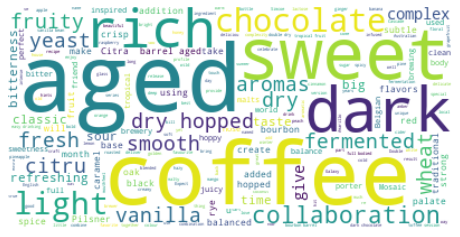

In [244]:
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Looking at different word clouds for beers under/over 3.96/5 rating:

### Beers rated >= 3.96.0

In [9]:
over_target_text = " ".join(review for review in beers_with_desc[beers_with_desc['rating']>= 3.96].beer_desc)

In [10]:
over_target_text[0:500]

'A classic interpretation of the native Dusseldorf style. Burgundy in color and possessing deep notes of raisin, bran flake, and light treacle, yet with a snappy and crisp palate. The malt character is balanced with an amply bitter character achieved with early kettle additions of classic German low-alpha hop varietals. The Rainbow Project paired seven UK and US breweries with one of seven colors of the rainbow, creating the theme of the brew. We drew violet. What followed was left to the imagina'

In [13]:
wordcloud_over_target = WordCloud(stopwords=stopwords, background_color="white").generate(over_target_text)

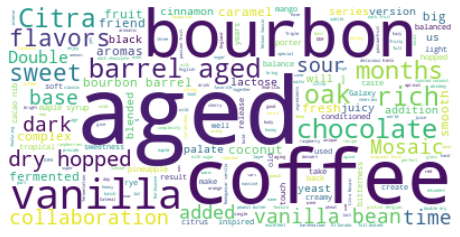

In [14]:
plt.figure(figsize=(8,6))
plt.imshow(wordcloud_over_target, interpolation='bilinear')
plt.axis("off")
plt.show()

### Beers rated < 3.96

In [15]:
under_target_text = " ".join(review for review in beers_with_desc[beers_with_desc['rating']< 3.96].beer_desc)

In [16]:
under_target_text[0:500]

'Collaboration with Magic Rock Beechwood smoked malt meets a double altbier.\nStrong, rich and full bodied. 12.4° Plato | OG 1050 | ABV 4.9%\n\nWylam & Left Handed Giant come together to create a Dussledorf\nAltbier. A complete Bamberg malt bill complemented by a German yeast strain, true Dussledorf water profile and topped off with pale Rye. \n\nHallertau Magnum & Manderina Baveria Hops complete the set followed by 4 weeks of lagering at zero degrees serving up\nan Altbier true to style and tradition. '

In [17]:
wordcloud_under_target = WordCloud(stopwords=stopwords, background_color="white").generate(under_target_text)

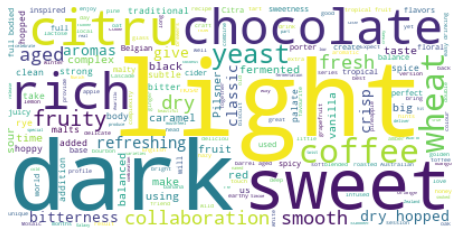

In [18]:
plt.figure(figsize=(8,6))
plt.imshow(wordcloud_under_target, interpolation='bilinear')
plt.axis("off")
plt.show()

THOUGHTS:

- There appears to be stark differences in the words that rate highly for beers > 3.96 rating and those under that target mark.
- From this I think it is worth investigating further how tasting notes can inform what makes a successful beer and how tastes have changed over time.

# Function to clean words:

In [32]:
# Function to apply all the steps in Section 2 above:

def get_words(df, col):
    
    words = (list([a for b in df[col].tolist() for a in b]))
    
    clean_words = preprocess(words)
    
    lower_words = [w.lower() for w in clean_words]
    
    useful_words = [word for word in lower_words if word not in stop_words]
    
    lemmed_words = [lem.lemmatize(word) for word in useful_words]
    
    final_words = [word for word in lemmed_words if word not in my_list]
    
    return(final_words)

## Applying the function to >=3.96 and <3.96 in the dataframe:

### Over 3.96

In [33]:
over_target_words = get_words(beers_with_desc[beers_with_desc['rating']>=3.96], 'tokenized_column')

In [34]:
over_target_common_words = [i[0] for i in FreqDist(over_target_words).most_common(20)]
print(over_target_common_words)

['barrel', 'aged', 'coffee', 'vanilla', 'bourbon', 'chocolate', 'citra', 'fruit', 'oak', 'dark', 'double', 'dry', 'mosaic', 'bean', 'hopped', 'rich', 'coconut', 'oat', 'sour', 'sugar']


In [35]:
over_target_fdist = FreqDist(over_target_words)
over_target_tasting_notes_df = pd.DataFrame.from_dict(over_target_fdist, orient='index')
over_target_tasting_notes_df.columns = ['Frequency']
over_target_tasting_notes_df.index.name = 'Tasting_Note'

In [36]:
over_target_tasting_notes_df = over_target_tasting_notes_df.reset_index().sort_values(by = 'Frequency', ascending = False)
over_target_tasting_notes_df.head()

,Tasting_Note,Frequency
106,barrel,2012
104,aged,1406
611,coffee,1081
476,vanilla,978
273,bourbon,934


In [37]:
#  Getting the total amount of words in the dataframe:
total_freq_over = over_target_tasting_notes_df.Frequency.sum()

In [38]:
over_target_tasting_notes_df["perc"] = over_target_tasting_notes_df.Frequency/total_freq_over
over_target_tasting_notes_df.head()

,Tasting_Note,Frequency,perc
106,barrel,2012,0.018646
104,aged,1406,0.013030
611,coffee,1081,0.010018
476,vanilla,978,0.009063
273,bourbon,934,0.008656


### Under 3.96:

In [39]:
under_target_words = get_words(beers_with_desc[beers_with_desc['rating']<3.96], 'tokenized_column')

In [40]:
under_target_common_words = [i[0] for i in FreqDist(under_target_words).most_common(20)]
print(under_target_common_words)

['dry', 'fruit', 'yeast', 'dark', 'chocolate', 'coffee', 'barrel', 'light', 'wheat', 'citrus', 'rich', 'sweet', 'hopped', 'bitterness', 'smooth', 'aged', 'refreshing', 'crisp', 'full', 'fruity']


In [41]:
under_target_fdist = FreqDist(under_target_words)
under_target_tasting_notes_df = pd.DataFrame.from_dict(under_target_fdist, orient='index')
under_target_tasting_notes_df.columns = ['Frequency']
under_target_tasting_notes_df.index.name = 'Tasting_Note'

In [42]:
under_target_tasting_notes_df = under_target_tasting_notes_df.reset_index().sort_values(by = 'Frequency', ascending = False)
under_target_tasting_notes_df.head()

,Tasting_Note,Frequency
45,dry,2104
711,fruit,2071
26,yeast,2027
160,dark,2017
543,chocolate,1705


In [43]:
total_freq_under = under_target_tasting_notes_df.Frequency.sum()
under_target_tasting_notes_df["perc"] = under_target_tasting_notes_df.Frequency/total_freq_under
under_target_tasting_notes_df.head()

,Tasting_Note,Frequency,perc
45,dry,2104,0.006264
711,fruit,2071,0.006166
26,yeast,2027,0.006035
160,dark,2017,0.006005
543,chocolate,1705,0.005076


## Creating a dataframe of the top Overall Words:

In [44]:
fdist = FreqDist(final_words)
tasting_notes_df = pd.DataFrame.from_dict(fdist, orient='index')
tasting_notes_df.columns = ['Frequency']
tasting_notes_df.index.name = 'Tasting_Note'

In [45]:
tasting_notes_df = tasting_notes_df.reset_index().sort_values(by = 'Frequency', ascending = False)
tasting_notes_df.head()

,Tasting_Note,Frequency
229,barrel,3623
725,fruit,2767
599,coffee,2703
226,aged,2686
160,dark,2603


## Merging this with the Over/Under Dataframe:

In [49]:
combined_tasting_df = pd.merge(tasting_notes_df, over_target_tasting_notes_df, on = 'Tasting_Note', how = 'left')

In [50]:
combined_tasting_df = pd.merge(combined_tasting_df, under_target_tasting_notes_df, on = 'Tasting_Note', how = 'left')

In [51]:
combined_tasting_df.head(3)

,Tasting_Note,Frequency_x,Frequency_y,perc_x,Frequency,perc_y
0,barrel,3623,2012.0,0.018646,1611.0,0.004796
1,fruit,2767,696.0,0.006450,2071.0,0.006166
2,coffee,2703,1081.0,0.010018,1622.0,0.004829


- 'perc_x' represents the frequency that the tasting note appears in the descriptions of beers rated over 3.96/5, and 'perc_y' represents the frequency of the same word in the beers rated under 3.96.

In [52]:
# Renaming dataframe columns for understandability:

combined_tasting_df.rename(columns = {'Frequency_y': 'over_target_freq', 'perc_x': 'over_target_perc',
                          'Frequency': 'under_target_freq', 'perc_y': 'under_target_perc',}, inplace = True)

In [53]:
# Creating a column to assign which has the higher % frequency of the tasting note:

combined_tasting_df['more'] = np.where(combined_tasting_df['over_target_perc']>combined_tasting_df['under_target_perc'],
                                       'over', 'under')

In [54]:
combined_tasting_df[0:5]

,Tasting_Note,Frequency_x,over_target_freq,over_target_perc,under_target_freq,under_target_perc,more
0,barrel,3623,2012.0,0.018646,1611.0,0.004796,over
1,fruit,2767,696.0,0.006450,2071.0,0.006166,over
2,coffee,2703,1081.0,0.010018,1622.0,0.004829,over
3,aged,2686,1406.0,0.013030,1280.0,0.003811,over
4,dark,2603,586.0,0.005431,2017.0,0.006005,under


In [55]:
top_twenty_tasting_df = combined_tasting_df[0:19]

# Scatterplot of Relative Frequency of the Most Common Tasting Notes:

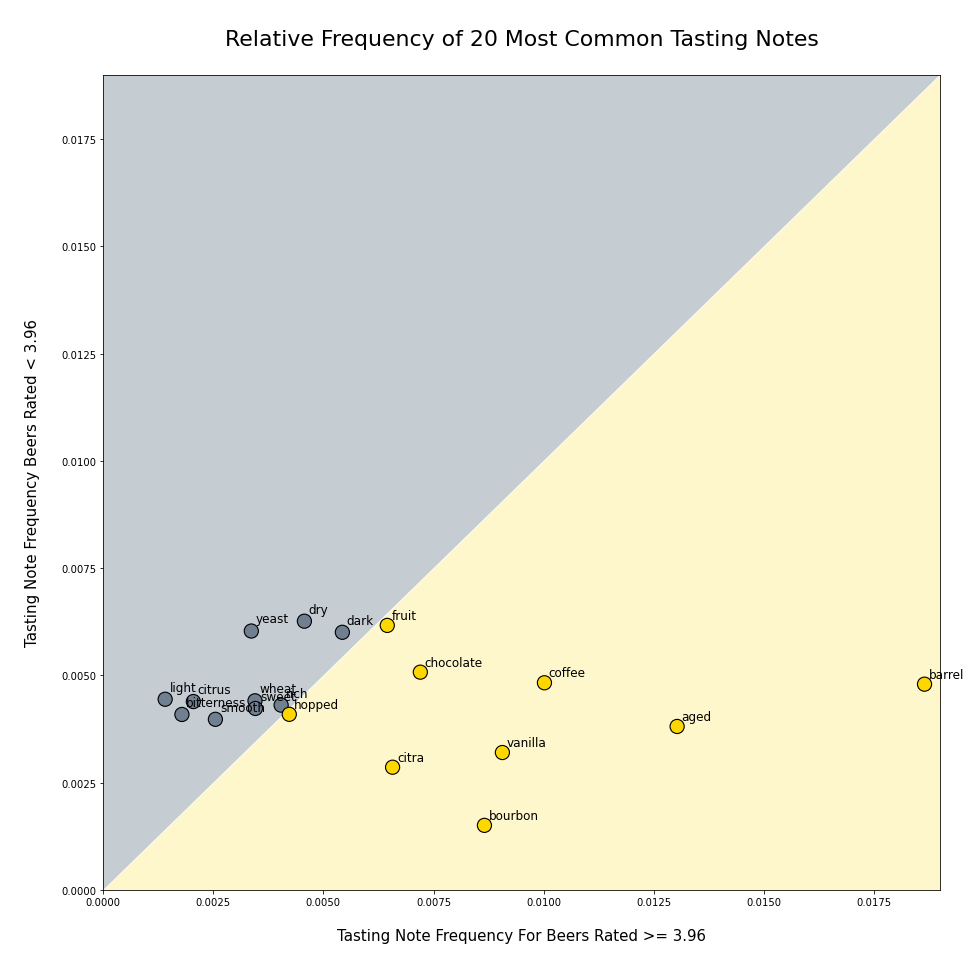

In [57]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
colors = ['gold', 'slategrey']

linestart = 0
lineend = 0.02

# Plotting the middle line, and filling above and below that line with different colors:
plt.fill_between([linestart, lineend], [linestart, lineend], facecolor="gold", edgecolor="b", linewidth=0.0, alpha = 0.2)
plt.fill_between([lineend, linestart], [lineend, linestart], 1, facecolor="slategrey", edgecolor="b", 
                 linewidth=0.0, alpha = 0.4, interpolate = True)

# Plotting the scatterplot on top of the background:
g = sns.scatterplot(x='over_target_perc', y='under_target_perc', hue='more', data=top_twenty_tasting_df, 
                    s = 200, edgecolor = 'black', palette = colors, legend = False, alpha = 1)

# source: https://stackoverflow.com/questions/15910019/annotate-data-points-while-plotting-from-pandas-dataframe/15911372#15911372
def label_point(x, y, val, z, ax):  
    a = pd.concat({'x': x, 'y': y, 'z': z, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['z'] == 'over':
            ax.text(point['x']+0.0001, point['y']+0.00015, str(point['val']), color = 'black', size = 'large')
        else:
            ax.text(point['x']+0.0001, point['y']+0.0002, str(point['val']), color = 'black', size = 'large')

label_point(top_twenty_tasting_df.over_target_perc, top_twenty_tasting_df.under_target_perc, 
            top_twenty_tasting_df.Tasting_Note, top_twenty_tasting_df.more, ax)


plt.gca().set(xlim=(0, 0.019), ylim=(0, 0.019),
              xlabel='\nTasting Note Frequency For Beers Rated >= 3.96\n', ylabel='\nTasting Note Frequency Beers Rated < 3.96\n')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

plt.title("\nRelative Frequency of 20 Most Common Tasting Notes\n", fontsize=22)
plt.show()

- Since the chart is split equally, the dividing middle line represents the threshold where a tasting note is either more frequent in beers rated over 3.96 or under.

- We can see that there are several tasting notes, e.g. 'barrel', 'aged', 'coffee', 'vanilla' and 'bourbon' that are much more frequently used in higher rated beers.

- There are some words that are more frequent in the lower rated beers, e.g. 'light' and 'yeast' that may be offputting to consumers. However, for these notes they are closer to the central line and so the difference is less stark.

* Conclusion - due to the disparity observed in the relative frequency of tasting notes between the two target classes, adding in tasting notes as a feature should be worthwhile when creating a classification model.

# Filtering according to key tasting notes:

## Prepping a column with a list of words from the beer description:

In [342]:
# Cleaning up the tokenized column like I did with the bag of words above:

list_of_words = []

for i in range(len(beers_with_desc)):
    prep_1 = preprocess(beers_with_desc.tokenized_column[i])
    prep_2 = [w.lower() for w in prep_1]
    prep_3 = [word for word in prep_2 if word not in stop_words]
    prep_4 = [lem.lemmatize(word) for word in prep_3]
    prep_5 = [word for word in prep_4 if word not in my_list]
    list_of_words.append(prep_5)

In [343]:
beers_with_desc['prepped_words'] = list_of_words

In [344]:
# Dropping tokenized column now I've used it:

beers_with_desc.drop('tokenized_column', axis=1, inplace=True)

In [345]:
beers_with_desc.head(3)

,name,brewery,beer_style,abv,date_added,available,num_ratings,rating,beer_desc,beer_style_group,prepped_words
0,Exalted,Thornbridge Brewery,Altbier,4.5,10/06/2016,1,542,3.70,Collaboration with Magic Rock,Other,"[collaboration, magic, rock]"
1,Leaf,Orbit Beers London,Altbier,6.2,03/12/2014,1,783,3.67,Beechwood smoked malt meets a double altbier.\...,Other,"[beechwood, smoked, meet, double, altbier, str..."
2,Ctrl Alt Del,Wylam,Altbier,4.9,07/02/2016,1,318,3.65,12.4° Plato | OG 1050 | ABV 4.9%\n\nWylam & Le...,Other,"[plato, og, wylam, left, handed, giant, come, ..."


## Creating Boolean Columns regarding whether the beer_desc contains specific words:

In [130]:
len(combined_tasting_df)

30511

In [135]:
combined_tasting_df.head(3)

,Tasting_Note,Frequency_x,over_four_freq,over_four_perc,under_four_freq,under_four_perc,more
0,coffee,2687,908.0,0.009713,1795.0,0.004945,over
1,aged,2686,1209.0,0.012933,1477.0,0.004069,over
2,dark,2603,492.0,0.005263,2111.0,0.005816,under


In [152]:
combined_tasting_df.Frequency_x.quantile(0.99)

261.0

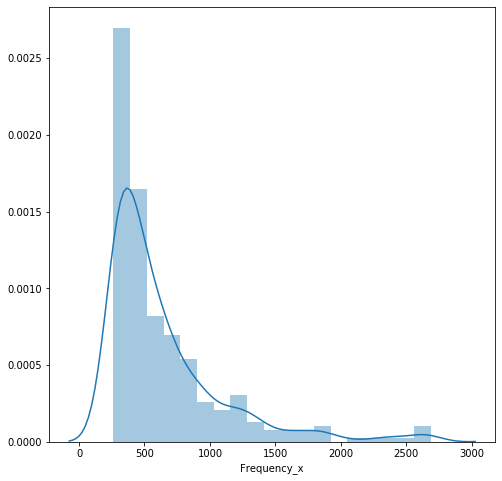

In [153]:
plt.figure(figsize = (8, 8))

sns.distplot(combined_tasting_df[combined_tasting_df['Frequency_x']>261].Frequency_x)

plt.show()

In [149]:
len(combined_tasting_df[combined_tasting_df['Frequency_x']>261])

305

In [129]:
combined_tasting_df.Tasting_Note[0:99].to_list()

['coffee',
 'aged',
 'dark',
 'dry',
 'chocolate',
 'fruit',
 'yeast',
 'vanilla',
 'rich',
 'malts',
 'wheat',
 'hopped',
 'sweet',
 'citrus',
 'citra',
 'light',
 'smooth',
 'bitterness',
 'bourbon',
 'tropical',
 'oak',
 'fresh',
 'barrel',
 'full',
 'red',
 'sour',
 'collaboration',
 'fermented',
 'caramel',
 'refreshing',
 'crisp',
 'black',
 'fruity',
 'balanced',
 'big',
 'aromas',
 'mosaic',
 'brewing',
 'body',
 'roasted',
 'belgian',
 'months',
 'rye',
 'classic',
 'orange',
 'complex',
 'double',
 'porter',
 'golden',
 'added',
 'clean',
 'oats',
 'us',
 'traditional',
 'will',
 'sweetness',
 'flavors',
 'barley',
 've',
 'time',
 'cider',
 'subtle',
 'base',
 'bitter',
 'using',
 'juicy',
 'pilsner',
 'taste',
 'malty',
 'perfect',
 'strong',
 'wine',
 'well',
 'soft',
 'spicy',
 'palate',
 'white',
 'brewery',
 'lactose',
 'coconut',
 'used',
 'mouthfeel',
 'give',
 'honey',
 'sugar',
 'tart',
 'best',
 'old',
 'take',
 'simcoe',
 'hoppy',
 'series',
 'back',
 'creamy',
 '

In [436]:
trial = ['magic', 'beechwood']

In [454]:
dataframe_list = []
for word in trial:
    word_bool =[]
    for row in beers_with_desc.prepped_words:
        if word in row:
            word_bool.append(1)
        else:
            word_bool.append(0)
    dataframe_list.append(word_bool)

In [462]:
dataframe_list = np.array(dataframe_list).T.tolist()

In [463]:
len(dataframe_list)

19373

In [465]:
pd.DataFrame(dataframe_list, columns = trial)

,magic,beechwood
0,1,0
1,0,1
2,0,0
3,0,0
4,0,0
...,...,...
19368,0,0
19369,0,0
19370,0,0
19371,0,0


# Corpus of Tasting Notes for LDA:

Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Creating the corpus:

In [295]:
beers_with_desc.head(3)

,name,brewery,beer_style,abv,date_added,available,num_ratings,rating,beer_desc,beer_style_group,prepped_words
0,Exalted,Thornbridge Brewery,Altbier,4.5,10/06/2016,1,542,3.70,Collaboration with Magic Rock,Other,"[collaboration, magic, rock]"
1,Leaf,Orbit Beers London,Altbier,6.2,03/12/2014,1,783,3.67,Beechwood smoked malt meets a double altbier.\...,Other,"[beechwood, smoked, malt, meet, double, altbie..."
2,Ctrl Alt Del,Wylam,Altbier,4.9,07/02/2016,1,318,3.65,12.4° Plato | OG 1050 | ABV 4.9%\n\nWylam & Le...,Other,"[plato, og, abv, wylam, left, handed, giant, c..."


In [346]:
desc_words = beers_with_desc.prepped_words.to_list()

In [347]:
desc_words[0]

['collaboration', 'magic', 'rock']

- "Gensim creates a unique id for each word in the document. The produced corpus is a mapping of (word_id, word_frequency)."

In [348]:
id2word = corpora.Dictionary(desc_words)

In [349]:
corpus = [id2word.doc2bow(text) for text in desc_words]

In [350]:
corpus[0]

[(0, 1), (1, 1), (2, 1)]

In [351]:
id2word[0]

'collaboration'

In [352]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('collaboration', 1), ('magic', 1), ('rock', 1)]]

# Building the Topic Model:

- Again using the source here: Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

- First I will try to build the model based on the whole dataset, and then I will build one just using the training set. 
- I am doing this because when I feed my features into the random forest model, I don't want the LDA model to have 'seen' the features/target in X_test and y_test.
- My process flow will be as follows:
    - Trial out LDA model on entire dataset to see how it works.
    - Split the beers dataframe into a training and test set.
    - Train an LDA model just on that training set to get X number of topics (see Notebook 5 - Preparing X_train...)
    - Apply that trained model to the features in my X_test set to get topics for the test set.
    - The training of the model will be in 'Notebook 6 - Random Forest Model Creation' Jupyter Notebook.

## LDA Model:

In [378]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,       # no. of topics to create
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,     # no. documents used in each training chunk
                                           passes=10,         # no. training passes
                                           alpha='auto',
                                           per_word_topics=True)

- Below are the top 5 model topics. within each of these topics there are listed the top 10 keywords that contribute to each topic.
- i.e. for topic six, the weight of 'barrel' keyword on that topic is 0.234, and 'aged' is 0.159.
- The topic makes intuitive sense as beers are normally barrel-aged in bourbon or oak barrels, which also appear in topic 0.

In [380]:
lda_model.print_topics()[6:7]

[(6,
  '0.343*"barrel" + 0.234*"aged" + 0.159*"bourbon" + 0.113*"oak" + 0.040*"barrelaged" + 0.022*"aging" + 0.007*"extended" + 0.004*"draft" + 0.003*"brewmaster" + 0.000*"maple"')]

In [381]:
doc_lda = lda_model[corpus]

In [382]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better. It is the measure of how well 
# the model performs on a held-back test set, measured as normalized log-liklihood.

# Compute Coherence Score
# Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.
coherence_model_lda = CoherenceModel(model=lda_model, texts=desc_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -17.83057493045471

Coherence Score:  0.3660404882937741


## Visualizing the topics:

In [383]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\rozhouse\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.287437  0.350662       1        1  16.633911
14    -0.195012 -0.106830       2        1  12.194517
2     -0.230790 -0.292553       3        1  11.311887
1     -0.075558 -0.013192       4        1   7.513540
15    -0.051853 -0.007827       5        1   5.277156
0     -0.001388  0.000767       6        1   4.964683
3     -0.000330  0.000804       7        1   4.562567
16     0.024190  0.003720       8        1   4.461012
9     -0.033549 -0.004282       9        1   4.253437
13     0.040896  0.005207      10        1   3.797083
6     -0.098205 -0.020505      11        1   3.630343
19     0.086117  0.008615      12        1   3.586202
8      0.088641  0.008780      13        1   3.000310
4      0.086030  0.008587      14        1   2.885509
10     0.090376  0.008834      15        1   2.725290
12     0.092862  0.008979      16        1   2.462643
17     0.105138  0.009619      17        1   2.354352
5      0.117053  0.010118      18        1   1.536046
11     0.113164  0.009957      19        1   1.495880
18     0.129654  0.010541      20        1   1.353635, topic_info=     Category         Freq       Term        Total  loglift  logprob
612   Default  6251.000000      wheat  6251.000000  30.0000  30.0000
219   Default  5528.000000     barrel  5528.000000  29.0000  29.0000
595   Default  5724.000000     coffee  5724.000000  28.0000  28.0000
560   Default  7509.000000  chocolate  7509.000000  27.0000  27.0000
217   Default  3765.000000       aged  3765.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
1946  Topic20     0.062863       zest     1.608290   1.0604 -11.4676
5455  Topic20     0.062860   berliner     1.608046   1.0605 -11.4676
2263  Topic20     0.062863       gold     1.608365   1.0604 -11.4675
2609  Topic20     0.062864        nib     1.608903   1.0600 -11.4675
2415  Topic20     0.062864       milk     1.609107   1.0599 -11.4675

[756 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
197      10  0.984970  achieved
895       5  0.995671   acidity
1099      7  0.999120     added
636      10  0.996845    adding
198      10  0.999347  addition
...     ...       ...       ...
517       6  0.996085      word
234       4  0.998644     world
344       3  0.997583     would
43        5  0.999618     yeast
216      10  0.997919       yet

[489 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 15, 3, 2, 16, 1, 4, 17, 10, 14, 7, 20, 9, 5, 11, 13, 18, 6, 12, 19])

Interpreting the above model graph:
- The larger the bubble the more prevalent the topic
- A strong model should have bubbles spread throughout the quadrants (i.e. distinctly different from one another).

## Comparing an LDA Mallet Model:

In [ ]:
# To replicate the below you will need to download and unzip the following file:
# http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# Save it in a folder called 'new_mallet' in the C Drive.

In [373]:
os.environ.update({'MALLET_HOME': r'C:/new_mallet/mallet-2.0.8/'})

In [374]:
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [377]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=desc_words, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ')

[(8, [('perfect', 0.04017152996845426), ('day', 0.0358339905362776), ('summer', 0.03253154574132492), ('drink', 0.027750394321766562), ('drinking', 0.024053627760252366), ('easy', 0.021244085173501577), ('make', 0.01966679810725552), ('great', 0.016019321766561515), ('long', 0.015279968454258675), ('enjoy', 0.013406940063091483)]), (2, [('full', 0.07070866972719118), ('taste', 0.05371748192707509), ('fruity', 0.04158091921270645), ('refreshing', 0.03530156719962007), ('lemon', 0.03408791092818321), ('bodied', 0.027228114611366153), ('sweet', 0.024220357764761755), ('create', 0.019946176982744975), ('ginger', 0.019629570998891878), ('lime', 0.019049126695161206)]), (0, [('fruit', 0.09232163080407702), ('tropical', 0.06432616081540204), ('citrus', 0.06409966024915062), ('orange', 0.05078142695356738), ('juicy', 0.036557191392978486), ('soft', 0.032661381653454134), ('mango', 0.030939977349943373), ('pineapple', 0.02749716874292186), ('peach', 0.024144960362400904), ('hazy', 0.02237825594

- Coherence Score has increased from 36.6 to 59.2 from changing the LDA model algorithm to mallet, therefore I will use this approach for my model.

## Figuring out the optimal number of topics:

In [485]:
# Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [394]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=desc_words, start=2, limit=30, step=1)

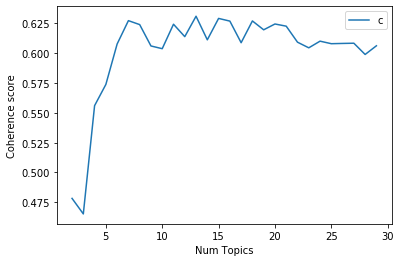

In [395]:
# Show graph
limit=30; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [400]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4783
Num Topics = 3  has Coherence Value of 0.4653
Num Topics = 4  has Coherence Value of 0.556
Num Topics = 5  has Coherence Value of 0.5738
Num Topics = 6  has Coherence Value of 0.6077
Num Topics = 7  has Coherence Value of 0.6273
Num Topics = 8  has Coherence Value of 0.624
Num Topics = 9  has Coherence Value of 0.6061
Num Topics = 10  has Coherence Value of 0.6038
Num Topics = 11  has Coherence Value of 0.6243
Num Topics = 12  has Coherence Value of 0.6139
Num Topics = 13  has Coherence Value of 0.631
Num Topics = 14  has Coherence Value of 0.6112
Num Topics = 15  has Coherence Value of 0.6292
Num Topics = 16  has Coherence Value of 0.6269
Num Topics = 17  has Coherence Value of 0.6088
Num Topics = 18  has Coherence Value of 0.6271
Num Topics = 19  has Coherence Value of 0.6196
Num Topics = 20  has Coherence Value of 0.6245
Num Topics = 21  has Coherence Value of 0.6227
Num Topics = 22  has Coherence Value of 0.6092
Num Topics = 23  has Coh

In [446]:
model_list[0]

In [402]:
max(coherence_values)

0.6309947421646521

- There is very little difference between the maximum coherence found at 13 topics and that of 0.6273 at 7 topics. 
- Above 13 topics the coherence starts to decline.

## Selecting the optimal model:

In [596]:
# Select the model at 8 topics (index no. 6, b/c idx[0]= 2 num. topics) and print the top 10 sub-topics:
# Selecting this model as I tried 7, 8 and 13 topics in the visualization below and 8 looks like a slightly more appropriate segmentation,
# given my domain knowledge
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.018*"refreshing" + 0.018*"magic" + 0.015*"hallertau" + 0.015*"baked" + 0.014*"elevated" + 0.014*"shortbread" + 0.013*"imited" + 0.013*"düsseldorf" + 0.010*"giant" + 0.009*"ongoing"'), (1, '0.050*"draft" + 0.049*"bodied" + 0.049*"left" + 0.039*"extinct" + 0.037*"munich" + 0.023*"deep" + 0.022*"annual" + 0.020*"started" + 0.018*"twist" + 0.018*"alt"'), (2, '0.043*"hook" + 0.035*"newlyfledged" + 0.032*"blur" + 0.027*"aramis" + 0.023*"sourdough" + 0.022*"specialty" + 0.020*"embrace" + 0.019*"hatter" + 0.016*"lagering" + 0.014*"undertone"'), (3, '0.031*"smoked" + 0.030*"rock" + 0.024*"prevent" + 0.024*"leicester" + 0.023*"traditional" + 0.018*"sthasherjnusfdpuf" + 0.018*"bitter" + 0.017*"steely" + 0.017*"dopplestike" + 0.016*"maneuver"'), (4, '0.029*"wird" + 0.028*"ti" + 0.024*"colder" + 0.016*"make" + 0.015*"floral" + 0.014*"original" + 0.014*"toasty" + 0.014*"palate" + 0.013*"lagering" + 0.011*"pint"'), (5, '0.023*"mouthfeel" + 0.018*"autumnspiced" + 0.013*"beautifully" + 0.012*"f

In [578]:
model_topics[0]

(0,
 [('yeast', 0.0305574809387068),
  ('sour', 0.026161006040202),
  ('collaboration', 0.025982770571343697),
  ('fermented', 0.025091593227052185),
  ('belgian', 0.021427864144964847),
  ('oak', 0.020952569561342706),
  ('wine', 0.01617981978413704),
  ('cherry', 0.012674522229923754),
  ('release', 0.011446677888899892),
  ('fermentation', 0.01140707000693138)])

- The above are the chosen topics from the optimal model.

# Dominant topic in each beer description:

In [413]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

## Dataframe of Dominant topic per description:

In [563]:
df_topic_sents_keywords = format_topics_sentences(optimal_model, corpus, desc_words)

In [564]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Description_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords_in_Topic', 'Text']

In [565]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'] + 1
df_dominant_topic.head(10)

,Description_No,Dominant_Topic,Topic_Perc_Contrib,Keywords_in_Topic,Text
0,0,1.0,0.1515,"yeast, sour, collaboration, fermented, belgian...","[collaboration, magic, rock]"
1,1,2.0,0.1907,"dark, rich, caramel, rye, bitter, complex, bar...","[beechwood, smoked, meet, double, altbier, str..."
2,2,2.0,0.1524,"dark, rich, caramel, rye, bitter, complex, bar...","[plato, og, wylam, left, handed, giant, come, ..."
3,3,7.0,0.1494,"fruit, dry, hopped, citra, tropical, mosaic, o...","[dry, hopped, altbier]"
4,4,1.0,0.4194,"yeast, sour, collaboration, fermented, belgian...","[brewdog, collabfest, last, thought, annual, f..."
5,5,2.0,0.1422,"dark, rich, caramel, rye, bitter, complex, bar...","[cask, conditioned, alt, bier, french, aramis,..."
6,6,2.0,0.2256,"dark, rich, caramel, rye, bitter, complex, bar...","[pours, deep, amber, colour, beautiful, reddis..."
7,7,6.0,0.2072,"fresh, cider, apple, honey, taste, tart, raspb...","[whilst, trying, get, festive, spirit, pair, c..."
8,8,8.0,0.1769,"smooth, full, black, sweet, bitterness, body, ...","[london, alt, original, dusseldorfstyle, old, ..."
9,9,2.0,0.2212,"dark, rich, caramel, rye, bitter, complex, bar...","[alt, meaning, old, throwback, yesteryear, bac..."


In [460]:
len(df_dominant_topic)

19373

In [461]:
len(beers_with_desc)

19373

## Visualizing the Topic Spread:

In [444]:
# First I have to convert the mallet model so that pyLDAvis can visualize it:

In [472]:
def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, 
                            alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

converted_model = ldaMalletConvertToldaGen(optimal_model)

In [473]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(converted_model, corpus, id2word, sort_topics=False)
vis

C:\Users\rozhouse\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\rozhouse\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\rozhouse\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\rozhouse\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.177740 -0.026137       1        1  12.532374
1      0.009285  0.253760       2        1  12.211241
2      0.225177  0.042205       3        1  12.078502
3     -0.126763 -0.264512       4        1  13.433060
4     -0.247921  0.228391       5        1  12.057083
5     -0.105306 -0.187092       6        1  12.415145
6      0.225219 -0.142908       7        1  12.579899
7      0.198050  0.096293       8        1  12.692698, topic_info=    Category         Freq       Term        Total  loglift  logprob
219  Default  3832.000000     barrel  3832.000000  30.0000  30.0000
595  Default  2859.000000     coffee  2859.000000  29.0000  29.0000
217  Default  2841.000000       aged  2841.000000  28.0000  28.0000
560  Default  2625.000000  chocolate  2625.000000  27.0000  27.0000
232  Default  2172.000000    vanilla  2172.000000  26.0000  26.0000
..       ...          ...        ...          ...      ...      ...
710   Topic8   947.151672      fruit  2902.896240   0.9441  -4.0855
5     Topic8   401.391052     bodied   563.556702   1.7248  -4.9441
66    Topic8   564.353638       give  1141.083984   1.3601  -4.6033
522   Topic8   306.238403       high   413.649597   1.7635  -5.2146
511   Topic8   334.674835      taste  1131.307861   0.8462  -5.1258

[631 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
895        1  0.938273        acidity
895        6  0.062552        acidity
15314      6  0.893762        actress
1099       1  0.340435          added
1099       3  0.012397          added
...      ...       ...            ...
10623      5  0.945365  ysbrydoliaeth
10624      5  0.945365          ystod
1946       3  0.999055           zest
12885      1  0.907876      zinfandel
27968      7  0.972008             âs

[739 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [464]:
pyLDAvis.save_html(vis, 'Figures/lda_topic_graph_8_topics.html')

- !! N.B. This will not be the model used to create the topics as it has been trained on the whole dataset.
- This was performed to compare the LDA and the Mallet model for appropriateness to this task.
- The next notebook will apply the best version of LDA (i.e. the Mallet Model) to the training set initially in the next notebook.

# Combining the topic dataframe with the beers with descriptions dataframe:

In [474]:
combined_df = pd.concat([beers_with_desc, df_dominant_topic], axis=1)

In [475]:
combined_df.head()

,name,brewery,beer_style,abv,date_added,available,num_ratings,rating,beer_desc,beer_style_group,prepped_words,Description_No,Dominant_Topic,Topic_Perc_Contrib,Keywords_in_Topic,Text
0,Exalted,Thornbridge Brewery,Altbier,4.5,10/06/2016,1,542,3.70,Collaboration with Magic Rock,Other,"[collaboration, magic, rock]",0,4.0,0.1515,"yeast, sour, collaboration, fermented, belgian...","[collaboration, magic, rock]"
1,Leaf,Orbit Beers London,Altbier,6.2,03/12/2014,1,783,3.67,Beechwood smoked malt meets a double altbier.\...,Other,"[beechwood, smoked, meet, double, altbier, str...",1,5.0,0.1907,"dark, rich, caramel, rye, bitter, complex, bar...","[beechwood, smoked, meet, double, altbier, str..."
2,Ctrl Alt Del,Wylam,Altbier,4.9,07/02/2016,1,318,3.65,12.4° Plato | OG 1050 | ABV 4.9%\n\nWylam & Le...,Other,"[plato, og, wylam, left, handed, giant, come, ...",2,5.0,0.1524,"dark, rich, caramel, rye, bitter, complex, bar...","[plato, og, wylam, left, handed, giant, come, ..."
3,Hades,Ghost Brew Co,Altbier,4.5,16/07/2016,1,228,3.62,Dry Hopped Altbier.,Other,"[dry, hopped, altbier]",3,10.0,0.1494,"fruit, dry, hopped, citra, tropical, mosaic, o...","[dry, hopped, altbier]"
4,Absolem's Alt,Mad Hatter Brewing Company,Altbier,5.4,31/10/2015,0,234,3.50,BrewDog #Collabfest 2015: Last year we thought...,Other,"[brewdog, collabfest, last, thought, annual, f...",4,4.0,0.4194,"yeast, sour, collaboration, fermented, belgian...","[brewdog, collabfest, last, thought, annual, f..."


In [476]:
# Dropping unneccesary columns:

combined_df.drop(['available', 'beer_desc', 'prepped_words', 'Description_No'], axis=1, inplace=True)

In [477]:
combined_df.head(3)

,name,brewery,beer_style,abv,date_added,num_ratings,rating,beer_style_group,Dominant_Topic,Topic_Perc_Contrib,Keywords_in_Topic,Text
0,Exalted,Thornbridge Brewery,Altbier,4.5,10/06/2016,542,3.70,Other,4.0,0.1515,"yeast, sour, collaboration, fermented, belgian...","[collaboration, magic, rock]"
1,Leaf,Orbit Beers London,Altbier,6.2,03/12/2014,783,3.67,Other,5.0,0.1907,"dark, rich, caramel, rye, bitter, complex, bar...","[beechwood, smoked, meet, double, altbier, str..."
2,Ctrl Alt Del,Wylam,Altbier,4.9,07/02/2016,318,3.65,Other,5.0,0.1524,"dark, rich, caramel, rye, bitter, complex, bar...","[plato, og, wylam, left, handed, giant, come, ..."


In [479]:
combined_df.to_csv('Datasets/beers_to_model.csv', index= False)

# Further Cleaning of the Dataset:
- In the next notebook I will apply the LDA Mallet model to my training data, so I need to clean the data some more and also save it to csv file.

## Cleaning the dataframe - removing unneccessary columns:

- **Name**: Should not have any significant effect on rating over a large sample size
- **Brewery**: Some of the top breweries may be more/less successful than others, but generally there are too many variables in this column to be useful.
- **date_added**: Changing to year and month columns as dimensionality reduction for this column.
- **available**: Refers to whether the beer is currently available, will remove as I don't think it would impact the model (see means below).
- **rating**: Will be converted to a binary column representing successful or not based on whether rating is >=3.96.
- **num_ratings**: I plan to leave this as it is, random forest should be able to deal with outliers.
- **beer_style**: This column is an extension of beer_style_group but I would hope Random Forest can use them in tandem.
- **Keywords in topic**: A description that is represented by the Dominant_Topic column
- **Text**: The raw text used to create the keywords in topic and dominant topic column

In [498]:
# Availability doesn't vary much by rating, and temporal impact on rating should be captured by the year and month columns:
print("Rating Average for Beers Currently Available:", mean(beers_with_desc[beers_with_desc['available']==1].rating))
print("Rating Average for Beers *Not* Currently Available:", mean(beers_with_desc[beers_with_desc['available']==0].rating))

Rating Average for Beers Currently Available: 3.7862548409624788
Rating Average for Beers *Not* Currently Available: 3.81002760905577


## Adding Year and Month columns:

In [490]:
beers_with_desc['month_added'] = pd.DatetimeIndex(beers_with_desc['date_added']).month
beers_with_desc['year_added'] = pd.DatetimeIndex(beers_with_desc['date_added']).year

## Creating a new column as the target - Success = 3.96 or above:

In [500]:
beers_with_desc['successful'] = np.where(beers_with_desc['rating']>=3.96, 'Yes', 'No')

In [501]:
beers_with_desc.head(3)

,name,brewery,beer_style,abv,date_added,available,num_ratings,rating,beer_desc,beer_style_group,prepped_words,month_added,year_added,successful
0,Exalted,Thornbridge Brewery,Altbier,4.5,10/06/2016,1,542,3.70,Collaboration with Magic Rock,Other,"[collaboration, magic, rock]",10,2016,No
1,Leaf,Orbit Beers London,Altbier,6.2,03/12/2014,1,783,3.67,Beechwood smoked malt meets a double altbier.\...,Other,"[beechwood, smoked, meet, double, altbier, str...",3,2014,No
2,Ctrl Alt Del,Wylam,Altbier,4.9,07/02/2016,1,318,3.65,12.4° Plato | OG 1050 | ABV 4.9%\n\nWylam & Le...,Other,"[plato, og, wylam, left, handed, giant, come, ...",7,2016,No


## Dropping Columns:

In [502]:
beers_with_desc.drop(['name', 'brewery', 'date_added', 'available', 'rating', 'beer_desc'], axis=1, inplace=True)

In [599]:
beers_with_desc.head(3)

,beer_style,abv,num_ratings,beer_style_group,prepped_words,month_added,year_added,successful
0,Altbier,4.5,542,Other,"[collaboration, magic, rock]",10,2016,No
1,Altbier,6.2,783,Other,"[beechwood, smoked, meet, double, altbier, str...",3,2014,No
2,Altbier,4.9,318,Other,"[plato, og, wylam, left, handed, giant, come, ...",7,2016,No


# Saving Dataframe:

In [ ]:
# Saving beers with descriptions file to csv to split into a training and test set in another notebook ('Preparing X_train and X_test for Modelling'):
beers_with_desc.to_csv('Datasets/beers_w_descriptions.csv', index= False)